In [2]:
#Perform pre-processing on the images to increase contrast between cells and background.
#Segment all cells by getting cell contours
#Display contours, each cell with a different colour - this must be consistent between image frames
#Given a contour, return appropriate information
    #Centroid position
    
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

#from skimage import measure, color, io


#from scipy import ndimage as ndi

#from skimage.segmentation import watershed
#from skimage.feature import peak_local_max

#from skimage import (
   # color, feature, filters, measure, morphology, segmentation, util
#)

#from multiprocessing import Pool

#from skimage.filters.rank import mean_bilateral

#from skimage import exposure

#from skimage.morphology import disk


In [32]:
MIN = 0
MAX = 2 ** 16 - 1

In [33]:
# import all images per sequence, return images
def import_sequences():
    PATH = '../sequences/0'
    imgs = []
    for i in range(1, 5):
        imgs_path = []
        for image in glob(f'{PATH}{i}/*.tif'):
            img = cv2.imread(image, -1)
            imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
        imgs.append(imgs_path)
    return imgs

In [4]:
def minMaxFilter(img, N, maxFilter):
    # maxFilter is a boolean, true = filter by max, else min

    imgAB = img.copy()
    
    height, width = img.shape
    
    pixelOffset = int((N-1)/2) #The number of ring pixels around the center of the kernel
    
    valueCoords = np.zeros([height,width,2], np.int32)
    valueCoords[:,:,:] = -1

    #valueCoords[:,:,0] <-- Row Values
    #valueCoords[:,:,1] <-- Col Values

    
    for row in range(height):
        for col in range(width):
        
            grayValue = img[row,col]
            valueCoords[row,col,0] = row
            valueCoords[row,col,1] = col
            
            #Boolean for if the left pixel from the current pixel got its 
            #Gray value where an overlap between NxN searches exist
            leftPixelRegion = False 
            abovePixelRegion = False
            
            if (col-1 >= 0):
                if (valueCoords[row,col-1,1] >= col-pixelOffset):
                    #Gray value found from NXN search of leftPixel overlaps with current Pixel NxN
                    leftPixelRegion = True
            if (row-1 >= 0):
                if (valueCoords[row-1,col,0] >= row-pixelOffset):
                    #Gray value found from NXN search of abovePixel overlaps with current Pixel NxN
                    abovePixelRegion = True
            
            if (leftPixelRegion == True and abovePixelRegion == True):
                #Compare gray values of left and above pixel, as well as the bottom right that isnt reached
                if (maxFilter == True):
                    if (imgAB[row,col-1] >= imgAB[row-1,col]):
                        #left pixel >= above pixel
                        grayValue = imgAB[row,col-1]
                        valueCoords[row,col,0] = valueCoords[row,col-1,0]
                        valueCoords[row,col,1] = valueCoords[row,col-1,1]
                    else:
                        #above pixel > left pixel
                        grayValue = imgAB[row-1,col]
                        valueCoords[row,col,0] = valueCoords[row-1,col,0]
                        valueCoords[row,col,1] = valueCoords[row-1,col,1]
                    
                    if (row+pixelOffset < height and col+pixelOffset < width):
                        #Ensure pixel is not out of bounds
                        if (img[row+pixelOffset,col+pixelOffset] >= grayValue):
                            #bottom right corner pixel
                            grayValue = img[row+pixelOffset,col+pixelOffset]
                            valueCoords[row,col,0] = row+pixelOffset
                            valueCoords[row,col,1] = col+pixelOffset
                
                
                else: # (maxFilter == False)
                    if (imgAB[row,col-1] <= imgAB[row-1,col]):
                        #left pixel <= above pixel
                        grayValue = imgAB[row,col-1]
                        valueCoords[row,col,0] = valueCoords[row,col-1,0]
                        valueCoords[row,col,1] = valueCoords[row,col-1,1]
                    else:
                        #left pixel > above pixel
                        grayValue = imgAB[row-1,col]
                        valueCoords[row,col,0] = valueCoords[row-1,col,0]
                        valueCoords[row,col,1] = valueCoords[row-1,col,1]
                    
                    if(row+pixelOffset < height and col+pixelOffset < width):
                        #Ensure pixel is not out of bounds
                        if (img[row+pixelOffset,col+pixelOffset] <= grayValue):
                            #bottom right corner pixel
                            grayValue = img[row+pixelOffset,col+pixelOffset]
                            valueCoords[row,col,0] = row+pixelOffset
                            valueCoords[row,col,1] = col+pixelOffset
              
            elif (leftPixelRegion == True and abovePixelRegion == False):
                #Compare gray value of left pixel with the right-most col of curr pixel
                grayValue = imgAB[row,col-1]
                valueCoords[row,col,0] = valueCoords[row,col-1,0]
                valueCoords[row,col,1] = valueCoords[row,col-1,1]
                
                x = col + pixelOffset
                if (x >= 0 and x < width):
                    for y in range((row - pixelOffset),(row + pixelOffset + 1)):
                        if (y >= 0 and y < height):
                            if (maxFilter == True):
                                if(img[y,x] >= grayValue):
                                    grayValue = img[y,x]
                                    valueCoords[row,col,0] = y #Row
                                    valueCoords[row,col,1] = x #Col
                            else: #(maxFilter == False)
                                if(img[y,x] <= grayValue):
                                    grayValue = img[y,x]
                                    valueCoords[row,col,0] = y #Row
                                    valueCoords[row,col,1] = x #Col
                
                
            elif (leftPixelRegion == False and abovePixelRegion == True):
                #Compare gray value of above pixel with the bottom-most row of curr pixel
                grayValue = imgAB[row-1,col]
                valueCoords[row,col,0] = valueCoords[row-1,col,0]
                valueCoords[row,col,1] = valueCoords[row-1,col,1]
                
                y = row + pixelOffset
                if (y >= 0 and y < height):
                    for x in range((col - pixelOffset),(col + pixelOffset + 1)):
                        if (x >= 0 and x < width):
                            if (maxFilter == True):
                                if(img[y,x] >= grayValue):
                                    grayValue = img[y,x]
                                    valueCoords[row,col,0] = y #Row
                                    valueCoords[row,col,1] = x #Col
                            else: #(maxFilter == False)
                                if(img[y,x] <= grayValue):
                                    grayValue = img[y,x]
                                    valueCoords[row,col,0] = y #Row
                                    valueCoords[row,col,1] = x #Col
            else:
                # Search NxN Pixels
                for y in range((row - pixelOffset),(row + pixelOffset + 1)):
                    if (y >= 0 and y < height):

                        for x in range((col - pixelOffset),(col + pixelOffset + 1)):
                            if (x >= 0 and x < width):

                                if (maxFilter == True):
                                    if(img[y,x] >= grayValue):
                                        grayValue = img[y,x]
                                        valueCoords[row,col,0] = y #Row
                                        valueCoords[row,col,1] = x #Col
                                else: #minFilter == True
                                    if (img[y,x] <= grayValue):
                                        grayValue = img[y,x]
                                        valueCoords[row,col,0] = y #Row
                                        valueCoords[row,col,1] = x #Col

            imgAB[row,col] = grayValue

                
    #print(imgAB)
    
    return imgAB

In [5]:
def backFilter(imgI, N, M):
    # M=0: Max-Filtering for ImgI to ImgA, then Min-Filtering for ImgA to ImgB, then subtraction (O=I-B) with correction
    # M=1: Min-Filtering for ImgI to ImgA, then Max-Filtering for ImgA to ImgB, then subtraction (O=I-B) with correction
    height, width = imgI.shape

    
    if(M==0):
        imgA = minMaxFilter(imgI, N, True) #Max Filter
        imgB = minMaxFilter(imgA, N, False) #Min Filter
        imgO = imgI.copy()
        imgO = np.subtract(imgI,imgB)
        imgO = np.add(imgO,65535.0)
        imgO[imgO > 65535.0] = 65535.0


    else:
        imgA = minMaxFilter(imgI, N, False) #Min Filter
        imgB = minMaxFilter(imgA, N, True) #Max Filter
        imgO = imgI.copy()
        imgO = np.subtract(imgI,imgB)
        imgO[imgO < 0.0] = 0.0

        
    
    imgI = np.uint16(imgI)
    imgA = np.uint16(imgA)
    imgB = np.uint16(imgB)
    imgO = np.uint16(imgO)
    

    fig, axs = plt.subplots(2, 2,figsize=(15,10))
    plt.tight_layout()

    axs[0, 0].imshow(imgI, cmap='gray', vmin=0,vmax=2**16)
    axs[0, 0].set_title('Image I')
    axs[0, 0].set(xticks=[], yticks=[])

    axs[0, 1].imshow(imgA, cmap='gray', vmin=0,vmax=2**16)
    axs[0, 1].set_title('Image A')
    axs[0, 1].set(xticks=[], yticks=[])

    axs[1, 0].imshow(imgB, cmap='gray', vmin=0,vmax=2**16)
    axs[1, 0].set_title('Image B')
    axs[1, 0].set(xticks=[], yticks=[])

    axs[1, 1].imshow(imgO, cmap='gray', vmin=0,vmax=2**16)
    axs[1, 1].set_title('Image O')
    axs[1, 1].set(xticks=[], yticks=[])
    
    for i in range(2):
        for y in range(2):
            axs[i,y].spines['top'].set_visible(False)
            axs[i,y].spines['right'].set_visible(False)
            axs[i,y].spines['bottom'].set_visible(False)
            axs[i,y].spines['left'].set_visible(False)
    
    
    return imgO

In [34]:
# Import Images
imgs = import_sequences()

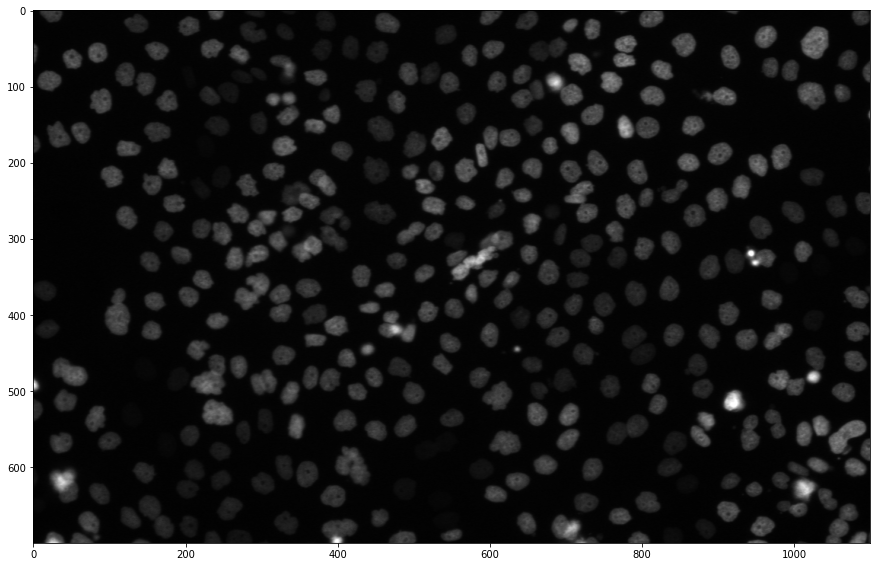

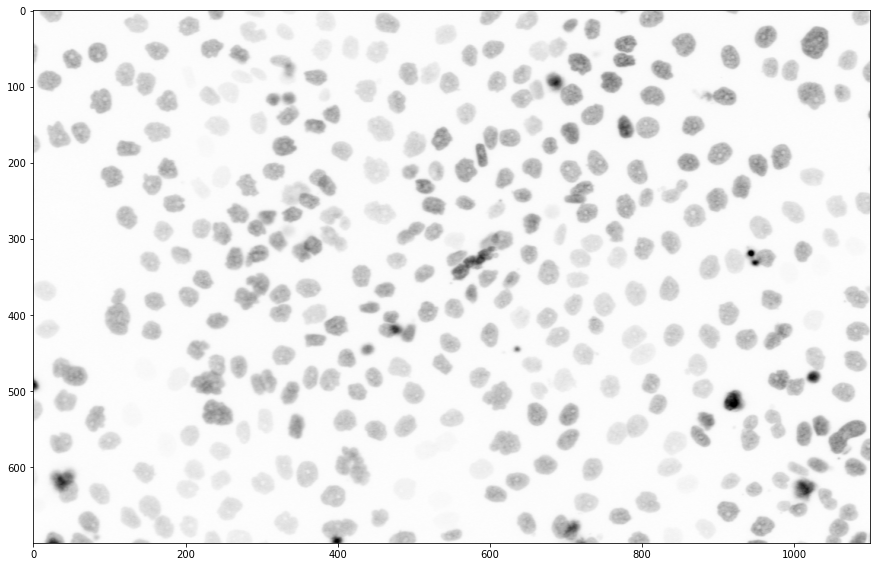

In [53]:
# Select Image for Analysis
img = imgs[1][90]
img_inv = cv2.bitwise_not(img)

plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray', vmin=0,vmax=2**16)

plt.figure(figsize=(15,15))
plt.imshow(img_inv, cmap='gray', vmin=0,vmax=2**16)

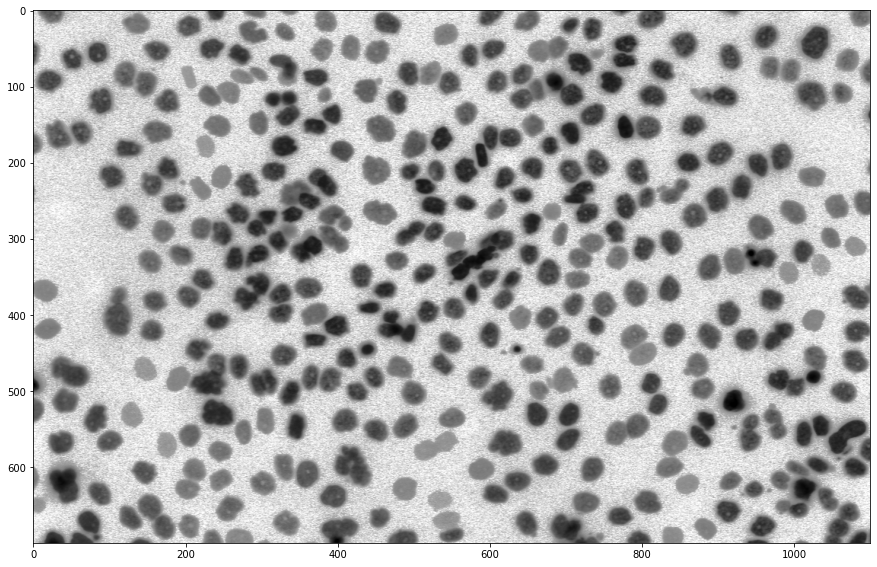

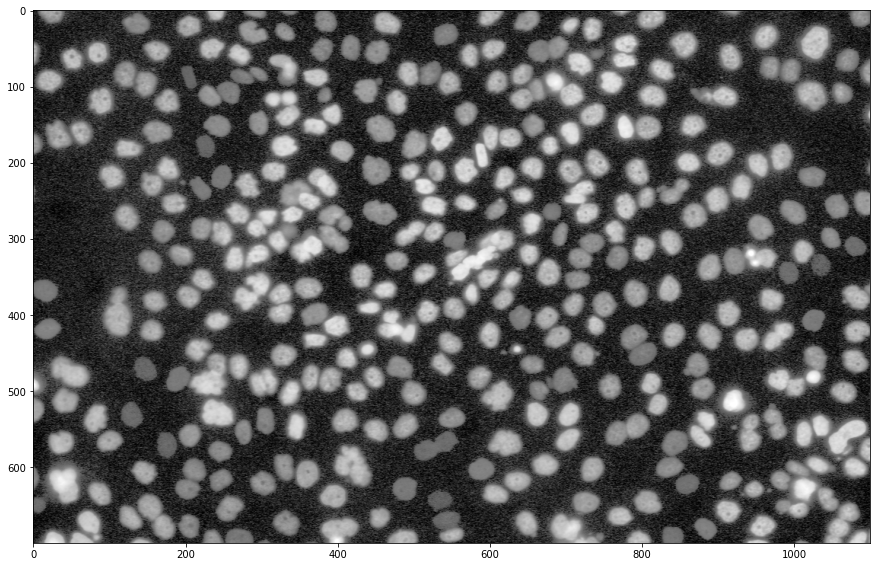

In [54]:
#Apply Clahe Filter
clahe = cv2.createCLAHE(clipLimit=500.0, tileGridSize=(5,5)) #40 (4,4)   #750 (20,20) #500 (5,5)
cl1 = clahe.apply(img_inv)
cl1_inv = cv2.bitwise_not(cl1)


plt.figure(figsize=(15,15))
plt.imshow(cl1, cmap='gray', vmin=0,vmax=2**16)

plt.figure(figsize=(15,15))
plt.imshow(cl1_inv, cmap='gray', vmin=0,vmax=2**16)

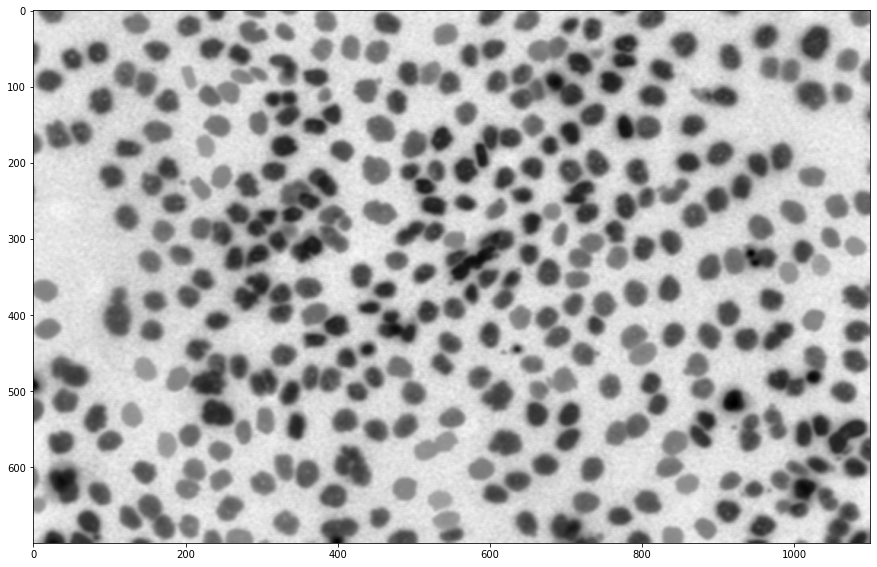

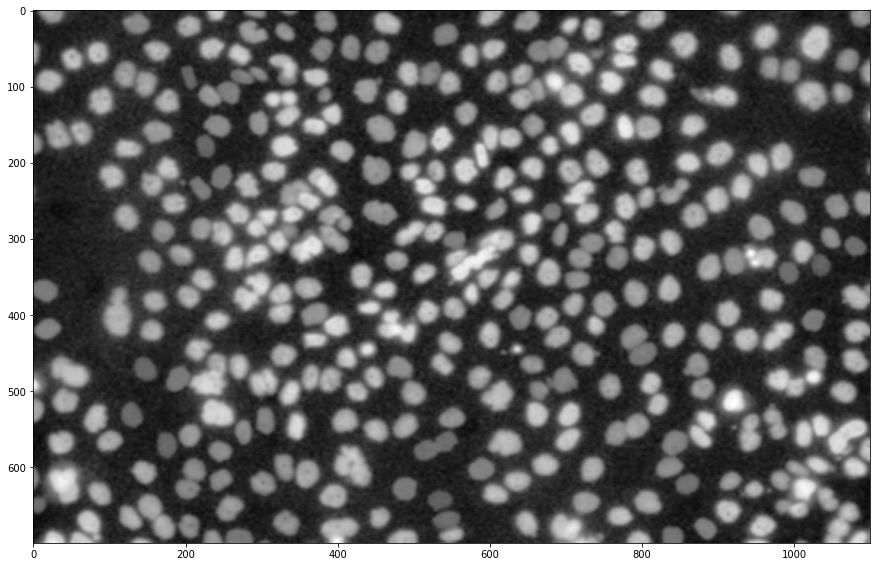

In [55]:
#img_func = np.float32(cl1_max)
img_func = cv2.GaussianBlur(cl1,(5,5),10)
img_func = np.float32(img_func)

img_func_inv = cv2.GaussianBlur(cl1_inv,(5,5),10)
img_func_inv = np.float32(img_func_inv)

plt.figure(figsize=(15,15))
plt.imshow(img_func, cmap='gray', vmin=0,vmax=2**16)

plt.figure(figsize=(15,15))
plt.imshow(img_func_inv, cmap='gray', vmin=0,vmax=2**16)

In [11]:
#imgO = backFilter(img_func, 35, 0)
#plt.figure(figsize=(15,15))
#plt.imshow(imgO, cmap='gray', vmin=0,vmax=2**16)

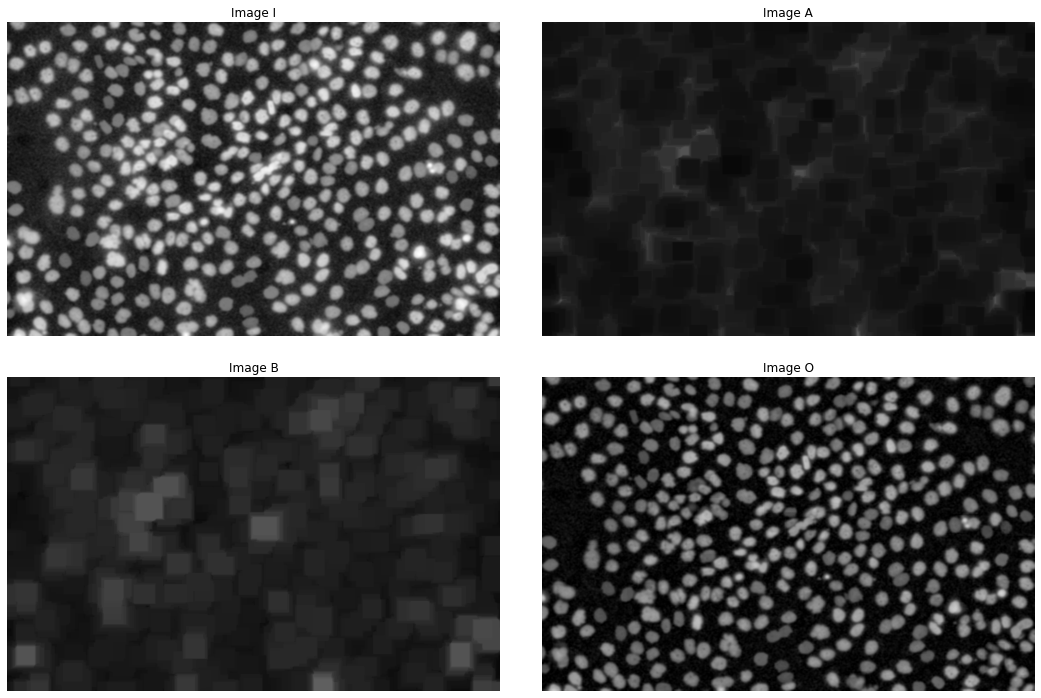

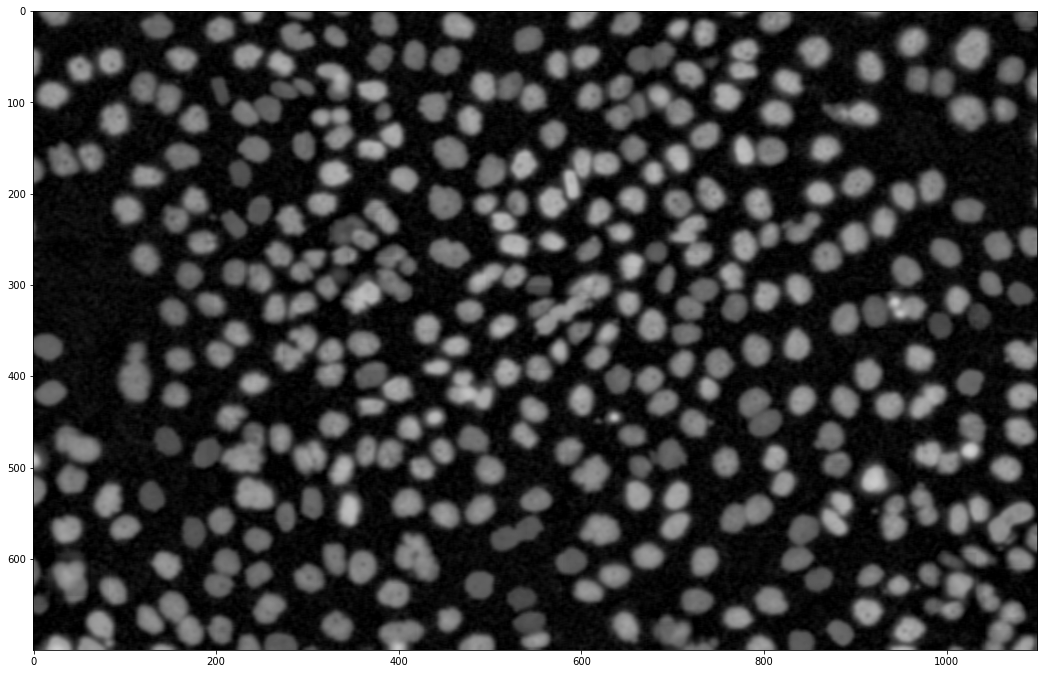

In [56]:
imgO_inv = backFilter(img_func_inv, 40, 1) #40 seems pretty good

plt.figure(figsize=(18,18))
plt.imshow(imgO_inv, cmap='gray', vmin=0,vmax=2**16)

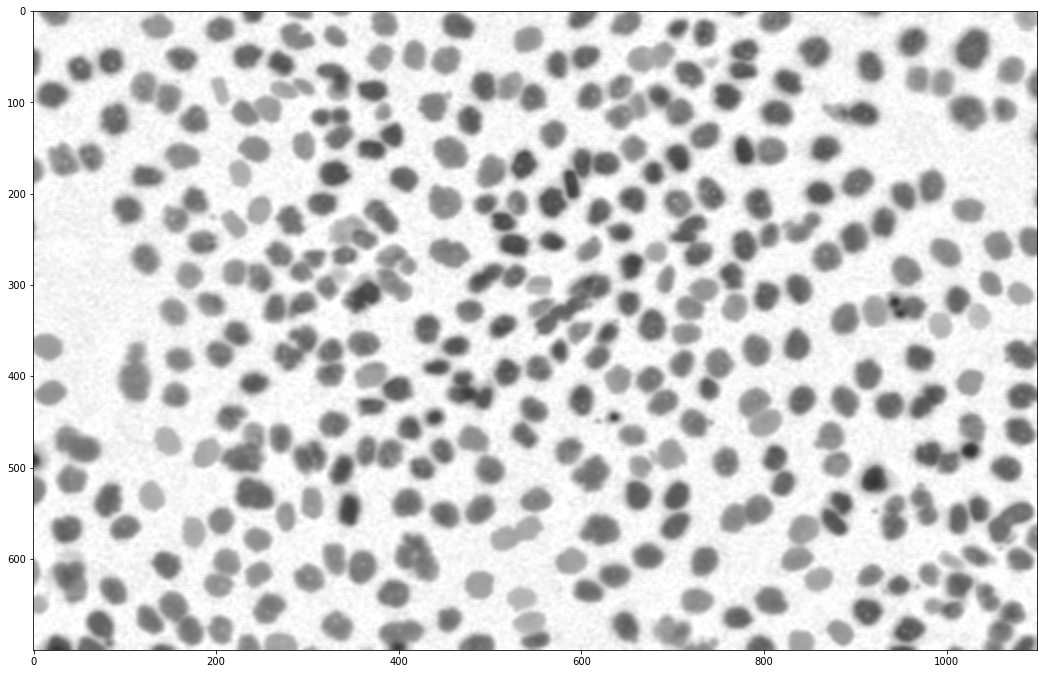

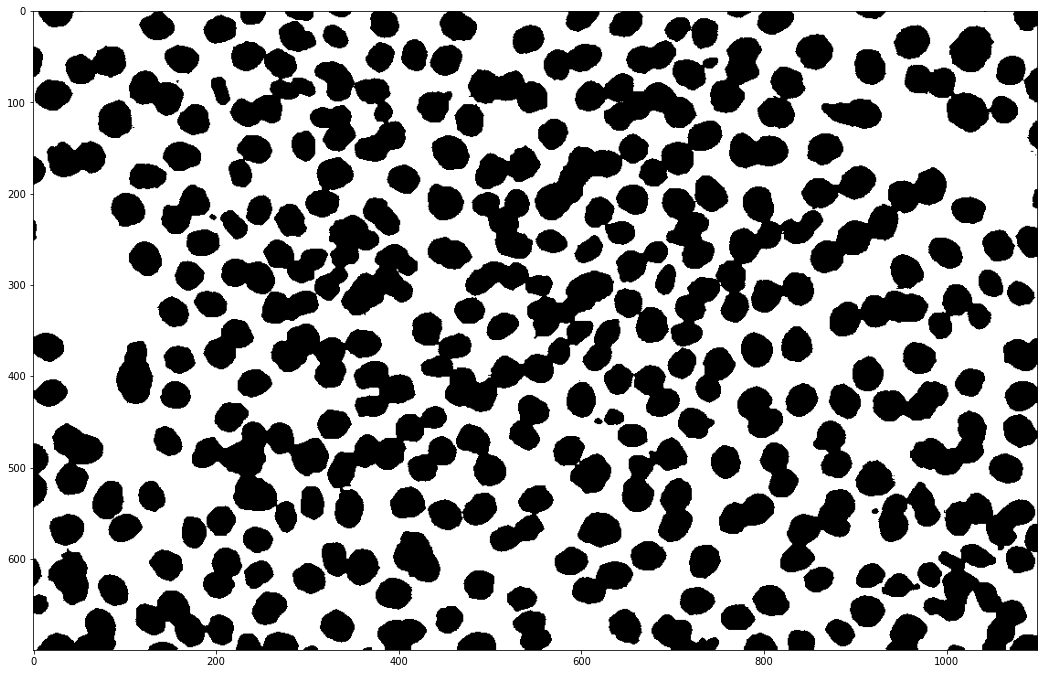

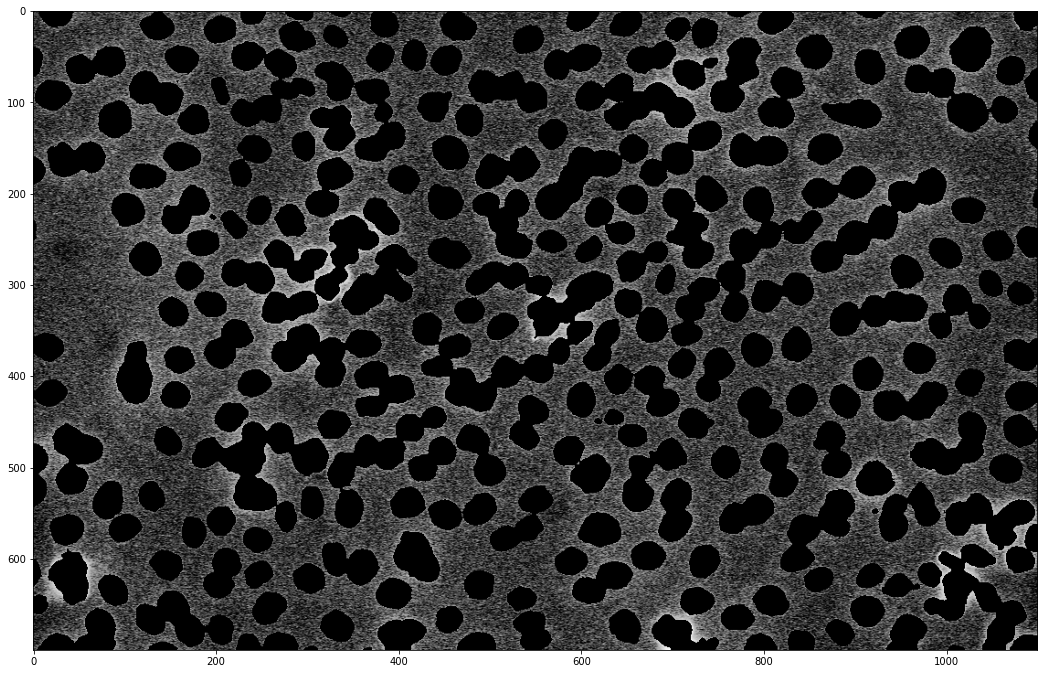

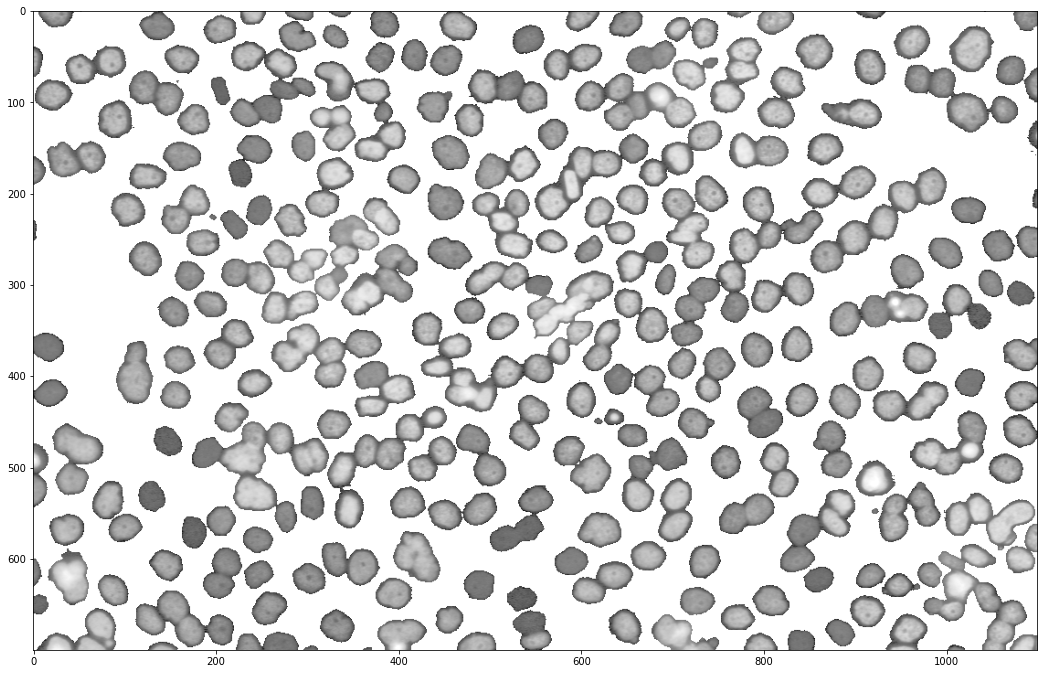

In [57]:
imgO3 = cv2.bitwise_not(imgO_inv)

#imgO_inv1 = backFilter(imgO_inv, 40, 1) #40 seems pretty good

plt.figure(figsize=(18,18))
plt.imshow(imgO3, cmap='gray', vmin=0,vmax=2**16)



ret1, thresh = cv2.threshold(imgO3, 56000, 65535, cv2.THRESH_BINARY) #50000 #54000
thresh_inv = cv2.bitwise_not(thresh)

plt.figure(figsize=(18,18))
plt.imshow(thresh, cmap='gray')



test = cv2.bitwise_and(cl1_inv,thresh)

plt.figure(figsize=(18,18))
plt.imshow(test, cmap='gray')



test1 = cv2.bitwise_or(cl1_inv,thresh)

plt.figure(figsize=(18,18))
plt.imshow(test1, cmap='gray')


In [ ]:
# #########################################################################################
# WARNING       -       PLOTTING HISTOGRAM OF 16-BIT IMAGE IS SLOW, takes around 1.5mins
# #########################################################################################


plt.figure(figsize=(18,18))
plt.hist(imgO_inv.ravel(),2**16,[0,2**16])   #histtype='stepfilled'
plt.axis([0,2**16,0, 300])

In [ ]:
#######################################################
# THE CODE BELOW IS NOT BEING USED
#######################################################

In [ ]:
kernel = np.ones((3,3), np.uint16)
#img_e = cv2.erode(imgO_inv, kernel, iterations=1)
#img_d = cv2.dilate(imgO_inv, kernel, iterations=1)
opening = cv2.morphologyEx(imgO_inv, cv2.MORPH_OPEN, kernel, iterations=1)


plt.figure(figsize=(18,18))
plt.imshow(opening, cmap='gray', vmin=0,vmax=2**16)


In [ ]:
arrayO = np.array(imgO)
print(arrayO.dtype)

imgO_s = imgO.copy()
height, width = imgO.shape

a = 0
b = 65535
c = arrayO.min() #min pixel value in img
d = arrayO.max() #max pixel value in img
print(c)
print(d)

for x in range(width):
    for y in range(height):
            imgO_s[y,x] = (imgO[y,x]-c)*((b-a)/(d-c))+a

#plt.hist(imgO.ravel(),2**16,[0,2**16])

plt.figure(figsize=(15,15))
plt.imshow(imgO_s, cmap='gray', vmin=0,vmax=2**16)



In [ ]:
#Apply Clahe for histogram equalisation
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(4,4))
cl1 = clahe.apply(img_inv)


plt.figure(figsize=(16,16))
plt.imshow(cl1, cmap='gray')

plt.figure(figsize=(5,5))
plt.hist(cl1.ravel(),256,[0,256]); plt.show()



In [ ]:
hist = cv2.calcHist([cl1],[0],None,[256],[0,256])

index = hist.argmax(axis=0)
freq = hist[index]
print(freq)
while freq != 0:
    index = index-1
    freq = hist[index]
    #print(index)
    #print(freq)

ret, thresh = cv2.threshold(cl1, index, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(16,16))
plt.imshow(thresh, cmap='gray')

In [ ]:
# The noise blob removing filter

img2 = cl1.copy()

img2[np.where(thresh == 0)] = 255

plt.figure(figsize=(16,16))
plt.imshow(img2, cmap='gray')

plt.figure(figsize=(5,5))
plt.hist(img2.ravel(),256,[0,256]); plt.show()


#blur = cv2.GaussianBlur(img2,(5,5),0)
#plt.figure(figsize=(16,16))
#plt.imshow(blur, cmap='gray')


In [ ]:

hist = cv2.calcHist([img2],[0],None,[256],[0,256])

max_index = 254
min_index = 0

while hist[max_index] == 0:
    max_index = max_index-1
    

while hist[min_index] == 0:
    min_index = min_index+1
    
    
height, width= img2.shape
img3 = img2.copy()

a = 50
b = 200
c = min_index #min pixel value in img
d = max_index #max pixel value in img
print(c)
print(d)

for x in range(width):
    for y in range(height):
        if img2[y,x] != 255:
            img3[y,x] = (img2[y,x]-c)*((b-a)/(d-c))+a


plt.figure(figsize=(16,16))
plt.imshow(img3, cmap='gray')

plt.figure(figsize=(5,5))
plt.hist(img3.ravel(),256,[0,256]); plt.show()

In [ ]:
blur = cv2.GaussianBlur(img3,(9,9),0)


plt.figure(figsize=(16,16))
plt.imshow(blur, cmap='gray')

plt.figure(figsize=(5,5))
plt.hist(blur.ravel(),256,[0,256]); plt.show()

In [ ]:
clahe2 = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(4,4))
cl2 = clahe2.apply(blur)

plt.figure(figsize=(16,16))
plt.imshow(cl2, cmap='gray')

plt.figure(figsize=(5,5))
plt.hist(cl2.ravel(),256,[0,256]); plt.show()


In [ ]:
img_inv2 = (255-cl2)
plt.figure(figsize=(16,16))
plt.imshow(img_inv2, cmap='gray')

In [ ]:
thresholds = filters.threshold_multiotsu(img_inv2, classes=3)
regions = np.digitize(img_inv2, bins=thresholds)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_inv2)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(regions)
ax[1].set_title('Multi-Otsu thresholding')
ax[1].axis('off')
plt.show()

cells = img_inv2 > thresholds[0]

In [ ]:
distance = ndi.distance_transform_edt(cells)

local_max_coords = feature.peak_local_max(distance, min_distance=7)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = measure.label(local_max_mask)

segmented_cells = segmentation.watershed(-distance, markers, mask=cells)

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].imshow(cells, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].axis('off')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
ax[1].axis('off')
plt.show()

In [ ]:
color_labels = color.label2rgb(segmented_cells, img, alpha=0.4, bg_label=0)

fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(color_labels)
ax.set_title('Segmentation result over raw image')
plt.show()

In [ ]:
##########################

In [ ]:
##############

In [ ]:
####################################